In [31]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# General Function to get  Direct Protein Potein intreaction as Features

In [32]:

# Constants for the STRING API
STRING_API_URL = "https://string-db.org/api"
OUTPUT_FORMAT = "tsv"
METHOD = "interaction_partners"
REQUEST_URL = f"{STRING_API_URL}/{OUTPUT_FORMAT}/{METHOD}"
SPECIES = 9606  # Human (NCBI Taxon ID)

def fetch_interaction_data(protein, species=SPECIES, limit=10):
    """
    Fetch interaction data for a given protein from the STRING API.

    Args:
        protein (str): The protein identifier (e.g., gene symbol or accession number).
        species (int): NCBI taxonomy ID for the species (default: 9606 for humans).
        limit (int): Maximum number of interactions to retrieve (default: 10).

    Returns:
        list: A list of interaction data lines (tsv format) or an empty list if the request fails.
    """
    params = {
        "identifiers": protein,
        "species": species,
        "limit": limit,
        "caller_identity": "Mohamed"
    }
    response = requests.post(REQUEST_URL, data=params)
    if response.ok:
        return response.text.strip().split("\n")
    else:
        print(f"Failed to fetch interactions for {protein}")
        return []

def check_direct_interaction(interactions_data, target_protein):
    """
    Check for direct interactions with a target protein in the fetched interaction data.

    Args:
        interactions_data (list): List of interaction data lines (tsv format).
        target_protein (str): The target protein identifier to check for interactions.

    Returns:
        list: A list of interaction records (lists of fields) where the target protein is found.
    """
    matching_interactions = []
    for line in interactions_data:
        fields = line.strip().split("\t")
        if len(fields) > 10 and fields[3] == target_protein:  # Match preferredName_B with target
            matching_interactions.append(fields)
    return matching_interactions

def get_direct_interaction(df1, gene1_col="Gene1", gene2_col="Gene2"):
    """
    Process a DataFrame of gene pairs and retrieve interaction scores.

    Args:
        df1 (pd.DataFrame): Input DataFrame containing gene pairs.
        gene1_col (str): The name of the column containing the first gene (default: "Gene1").
        gene2_col (str): The name of the column containing the second gene (default: "Gene2").

    Returns:
        pd.DataFrame: A DataFrame containing interaction scores and additional information
                      for each gene pair.
    """
    results = []
    for index, row in df1.iterrows():
        protein1, protein2 = row[gene1_col], row[gene2_col]
        
        # Fetch interaction data for the first protein
        interactions_data = fetch_interaction_data(protein1)
        
        # Check for direct interactions with the second protein
        interactions = check_direct_interaction(interactions_data, protein2)
        
        # Append interaction details or zeros if no interaction is found
        if interactions:
            for interaction in interactions:
                results.append({
                    gene1_col: protein1,
                    gene2_col: protein2,
                    "preferredName_A": interaction[2],
                    "preferredName_B": interaction[3],
                    "score": float(interaction[5]),
                    "nscore": float(interaction[6]),
                    "fscore": float(interaction[7]),
                    "pscore": float(interaction[8]),
                    "ascore": float(interaction[9]),
                    "escore": float(interaction[10]),
                    "dscore": float(interaction[11]),
                    "tscore": float(interaction[12]),
                })
            print(f"Processed interaction between {protein1} and {protein2}: Direct interaction found.")
        else:
            results.append({
                gene1_col: protein1,
                gene2_col: protein2,
                "preferredName_A": protein1,
                "preferredName_B": protein2,
                "score": 0,
                "nscore": 0,
                "fscore": 0,
                "pscore": 0,
                "ascore": 0,
                "escore": 0,
                "dscore": 0,
                "tscore": 0,
            })
            print(f"Processed interaction between {protein1} and {protein2}: No direct interaction found.")
            
    return pd.DataFrame(results)


# General function to Extract Indirect Protein Protein Intreaction 

In [33]:


# Define the STRING API base URL and parameters
STRING_API_URL = "https://string-db.org/api"
OUTPUT_FORMAT = "tsv-no-header"
METHOD_INTERACTORS = "interaction_partners"
SPECIES = 9606  # Human (NCBI Taxonomy ID)

# Define a function to retrieve interaction partners for a given protein
def get_interaction_partners(protein):
    """
    Fetch interaction partners for a given protein using the STRING API.

    Args:
        protein (str): The protein identifier (e.g., gene symbol).

    Returns:
        set: A set of interaction partners for the protein.
    """
    request_url = f"{STRING_API_URL}/{OUTPUT_FORMAT}/{METHOD_INTERACTORS}"
    params = {
        "identifiers": protein,
        "species": SPECIES,
        "required_score": 400,  # Medium interaction confidence score 
        "caller_identity": "Mohamed"
    }
    
    # Make the API request
    response = requests.post(request_url, data=params)
    partners = set()
    
    if response.ok:
        # Parse the response text to extract interaction partners
        for line in response.text.strip().split("\n"):
            fields = line.strip().split("\t")
            # Check that we have enough fields and a valid interaction type
            if len(fields) > 10:  # Ensure we have at least 11 fields
                partner = fields[3]  # The partner's common name (4th column)
                score = fields[5]  # Interaction score (6th column)
                
                # Log the interaction type for informational purposes
                print(f"Found interaction for protein '{protein}': {partner} (score: {score})")
                
                partners.add(partner)
    
    return partners
# Define the main function to process the gene pairs DataFrame and compute interaction data
def get_indirect_interaction_data(gene_pairs_df, gene1_col="Gene1", gene2_col="Gene2"):
    """
    Process a DataFrame containing gene pairs and compute interaction data.

    Args:
        gene_pairs_df (pd.DataFrame): DataFrame containing gene pairs with columns for genes.
        gene1_col (str): The column name for the first gene (default is "Gene1").
        gene2_col (str): The column name for the second gene (default is "Gene2").

    Returns:
        pd.DataFrame: A DataFrame with interaction data and Jaccard index for each gene pair.
    """
    results_list = []

    # Iterate through each row in the DataFrame
    for index, row in gene_pairs_df.iterrows():
        protein1 = row[gene1_col]  
        protein2 = row[gene2_col]  

        # Retrieve interaction partners for both proteins
        partners1 = get_interaction_partners(protein1)
        partners2 = get_interaction_partners(protein2)

        # Find common interactors (intersection of partners)
        common_partners = partners1.intersection(partners2)

        # Calculate the union of interactors
        union_partners = partners1.union(partners2)

        # Calculate the Jaccard index (intersection / union)
        intersection_count = len(common_partners)
        union_count = len(union_partners)

        # Prevent division by zero
        jaccard_index = intersection_count / union_count if union_count > 0 else 0.0

        # Total number of unique proteins in both gene sets (union)
        total_proteins_count = len(partners1) + len(partners2) - intersection_count  # Union size

        # Prepare the result dictionary for the current gene pair
        common_proteins_str = ', '.join(common_partners) 
        results_list.append({
            gene1_col: protein1,
            gene2_col: protein2,
            "Gene_combination":  f"{protein1}_{protein2}",
            "Jaccard Index": jaccard_index,
            "Number of Common Proteins": intersection_count,
            "Total Unique Proteins": total_proteins_count,
            "Common Proteins": common_proteins_str
        })

    # Convert the list of results to a DataFrame
    results_df = pd.DataFrame(results_list)
    return results_df

# A General Function for Feature Distribution Visualization


In [34]:

def calculate_and_visualize_similarity_stats(df, similarity_columns):
    """
    Calculate and visualize basic statistics for each similarity column.

    Libraly needed :
    pandas
    matplotlib.pyplot
    seaborn

    Parameters:
        df (pd.DataFrame): The DataFrame containing similarity scores for various domains.
        similarity_columns (list): List of column names with similarity scores.

    Returns:
        dict: A dictionary containing descriptive statistics for each similarity column.
    """
    # Dictionary to hold the statistics for each similarity column
    stats_dict = {}
    
    # Set up the visualization layout
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(similarity_columns, 1):
        if col in df.columns:
            # Calculate statistics and store them
            stats_dict[col] = df[col].describe()
            
            # Plot histogram
            plt.subplot(3, len(similarity_columns), i)
            sns.histplot(df[col], kde=True, bins=15, color="skyblue", fill=True)  
            plt.title(f"Histogram of {col}")
            plt.xlabel("Similarity Score")
            plt.ylabel("Frequency")
            
            # Plot boxplot
            plt.subplot(3, len(similarity_columns), i + len(similarity_columns))
            sns.boxplot(y=df[col], color="lightcoral")
            plt.title(f"Box Plot of {col}")
            plt.xlabel("Similarity Score")

            # Plot density plot 
            plt.subplot(3, len(similarity_columns), i + 2 * len(similarity_columns))
            sns.kdeplot(df[col], fill=True, color="lightgreen")  
            plt.title(f"Density Plot of {col}")
            plt.xlabel("Similarity Score")
    
    plt.tight_layout()
    plt.show()
    
    return stats_dict

# Use the function to extract direct protein protein intreaction 

In [35]:
data = {
    'Gene1': ['ACTB', 'ACTG1', 'EGFR', 'MYC'],
    'Gene2': ['ACTG1', 'ACTB', 'MYC', 'EGFR']
}
df_gene_pairs = pd.DataFrame(data)

# Get direct intreaction
Direct_interaction_results = get_direct_interaction(df_gene_pairs, gene1_col="Gene1", gene2_col="Gene2")

# Display the results
print(Direct_interaction_results)



Processed interaction between ACTB and ACTG1: Direct interaction found.
Processed interaction between ACTG1 and ACTB: Direct interaction found.
Processed interaction between EGFR and MYC: No direct interaction found.
Processed interaction between MYC and EGFR: No direct interaction found.
   Gene1  Gene2 preferredName_A preferredName_B  score  nscore  fscore  \
0   ACTB  ACTG1            ACTB           ACTG1  0.999     0.0     0.0   
1  ACTG1   ACTB           ACTG1            ACTB  0.999     0.0     0.0   
2   EGFR    MYC            EGFR             MYC  0.000     0.0     0.0   
3    MYC   EGFR             MYC            EGFR  0.000     0.0     0.0   

   pscore  ascore  escore  dscore  tscore  
0   0.047   0.778   0.983     0.9   0.795  
1   0.047   0.778   0.983     0.9   0.795  
2   0.000   0.000   0.000     0.0   0.000  
3   0.000   0.000   0.000     0.0   0.000  


# Use the function to Extract Indirect protein protein Intreaction

In [36]:
# Get interaction data
indirect_interaction_results = get_indirect_interaction_data(df_gene_pairs, gene1_col="Gene1", gene2_col="Gene2")

# Display the results
print(indirect_interaction_results)

Found interaction for protein 'ACTB': PFN3 (score: 0.999)
Found interaction for protein 'ACTB': ACTL6A (score: 0.999)
Found interaction for protein 'ACTB': PFN1 (score: 0.999)
Found interaction for protein 'ACTB': ACTG1 (score: 0.999)
Found interaction for protein 'ACTB': CFL1 (score: 0.999)
Found interaction for protein 'ACTB': PFN4 (score: 0.999)
Found interaction for protein 'ACTB': SMARCA4 (score: 0.999)
Found interaction for protein 'ACTB': SMARCE1 (score: 0.996)
Found interaction for protein 'ACTB': CFL2 (score: 0.996)
Found interaction for protein 'ACTB': RUVBL2 (score: 0.995)
Found interaction for protein 'ACTG1': ACTB (score: 0.999)
Found interaction for protein 'ACTG1': CFL1 (score: 0.998)
Found interaction for protein 'ACTG1': CFL2 (score: 0.996)
Found interaction for protein 'ACTG1': PFN1 (score: 0.992)
Found interaction for protein 'ACTG1': MYH14 (score: 0.992)
Found interaction for protein 'ACTG1': PFN4 (score: 0.991)
Found interaction for protein 'ACTG1': VCL (score: 0.9

# Visualisation of he Intreaction


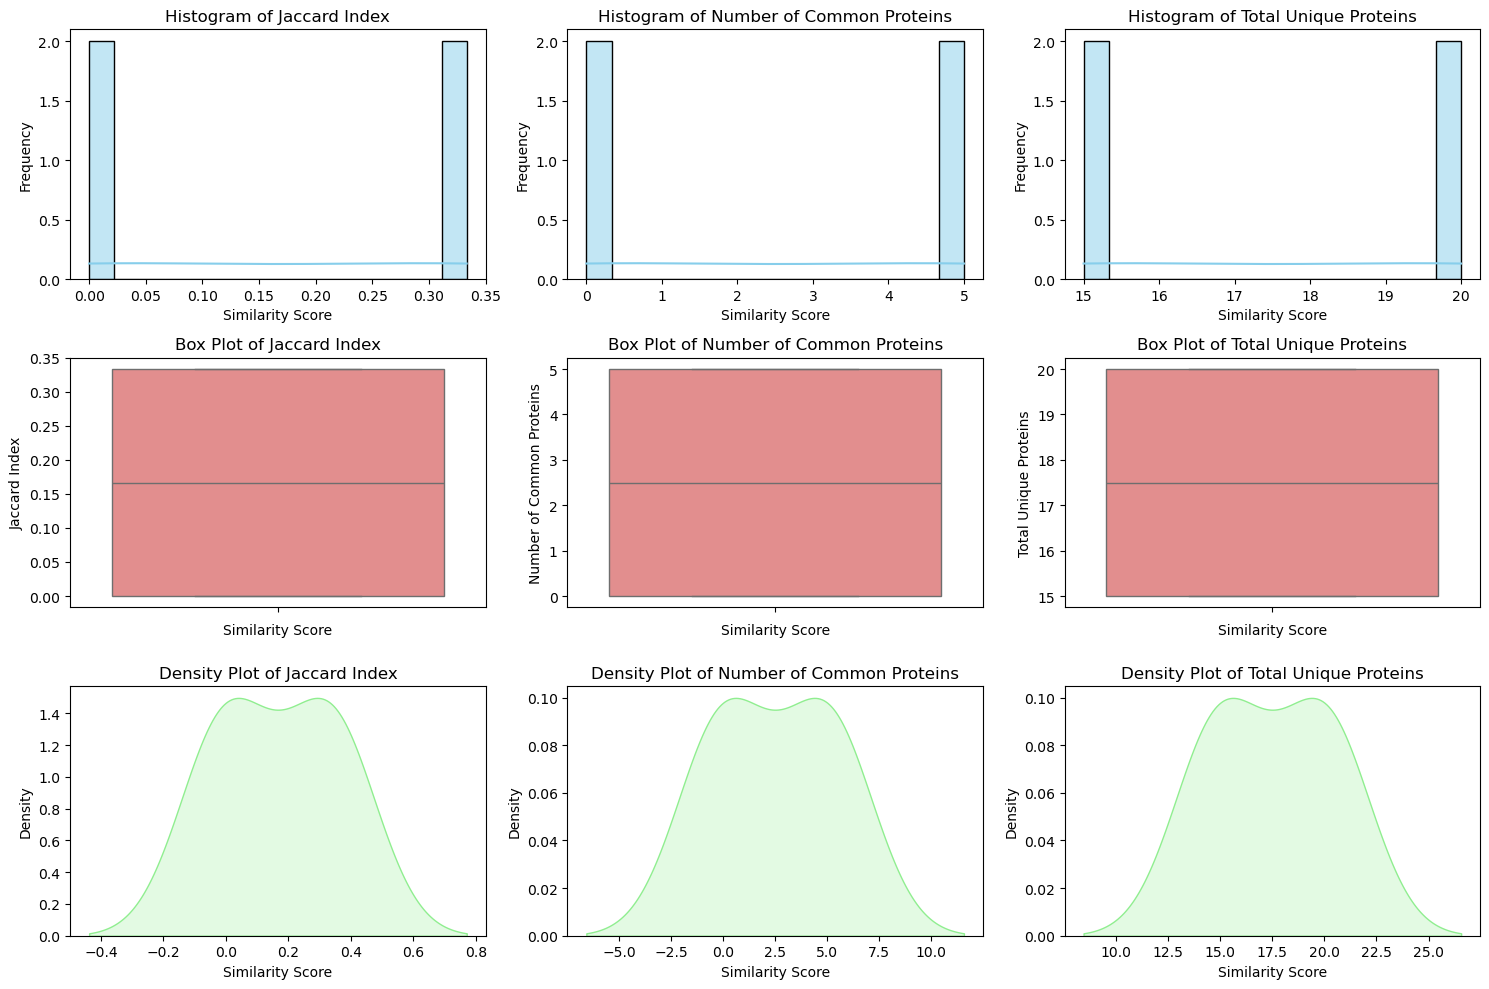

In [37]:
similarity_columns = ['Jaccard Index', 'Number of Common Proteins', 'Total Unique Proteins']
stats = calculate_and_visualize_similarity_stats(indirect_interaction_results,similarity_columns)
